In [67]:
import pandas as pd
import pm4py
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pm4py.objects.log.importer.xes import importer
from sklearn.model_selection import train_test_split

# Data Reading And Cleaning

In [39]:
# Read the event log CSV file
csv_file_path = 'event_log.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file_path)

# Convert 'start_time' column to datetime if it's not already
df['start_time'] = pd.to_datetime(df['start_time'])

# Find events where start_time equals end_time
events_same_start_end = df[df['start_time'] == df['completion_time']]

# Get list of event names where start and end times are the same
event_names_same_start_end = events_same_start_end['event_label'].unique().tolist()

# Display or further process event names where start and end times are the same
print("Event names where start and end times are the same:")
print(event_names_same_start_end)

Event names where start and end times are the same:
['emergency_patient', 'releasing', 'patient_referal', 'time_for_intake', 'patient_left_due_to_long_wait']


In [40]:
# Step 1: Load the original CSV file
df = pd.read_csv('event_log.csv')

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90430 entries, 0 to 90429
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   case_id          90430 non-null  int64 
 1   task_id          90430 non-null  int64 
 2   event_label      90430 non-null  object
 3   resource         90430 non-null  object
 4   start_time       90430 non-null  object
 5   completion_time  90430 non-null  object
 6   diagnosis        16238 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.8+ MB


In [66]:
# Check for null cells in the entire DataFrame
null_cells = df.isnull()
print(True in null_cells)

False


In [42]:
df.head(10)

,case_id,task_id,event_label,resource,start_time,completion_time,diagnosis
0,0,0,emergency_patient,None,2018-01-01 00:57:24.551134,2018-01-01 00:57:24.551134,None
1,0,2,ER_treatment,ER_PRACTITIONER3,2018-01-01 00:57:24.551134,2018-01-01 02:30:33.427464,NaN
2,0,3,releasing,None,2018-01-01 02:30:33.427464,2018-01-01 02:30:33.427464,NaN
3,1,1,emergency_patient,None,2018-01-01 03:03:14.397047,2018-01-01 03:03:14.397047,B2
4,1,5,ER_treatment,ER_PRACTITIONER3,2018-01-01 03:03:14.397047,2018-01-01 04:20:35.559032,NaN
5,2,4,emergency_patient,None,2018-01-01 06:16:04.316754,2018-01-01 06:16:04.316754,B1
6,3,7,emergency_patient,None,2018-01-01 07:06:12.075649,2018-01-01 07:06:12.075649,None
7,4,9,emergency_patient,None,2018-01-01 07:55:07.334212,2018-01-01 07:55:07.334212,B2
8,5,11,emergency_patient,None,2018-01-01 08:16:09.204766,2018-01-01 08:16:09.204766,B1
9,2,8,ER_treatment,ER_PRACTITIONER3,2018-01-01 06:16:04.316754,2018-01-01 08:38:28.243767,NaN


we now see that we have a lot of unneccesary columns so we will remove them and we will organize the events

In [43]:
# Define the function to modify the dataframe in place
def transform_event_label_and_resource(df):
    for index, row in df.iterrows():
        if row['resource'] != 'None':
            # Change the event_label to the resource value
            df.at[index, 'event_label'] = row['resource']
            # Change the resource to 'None'
            df.at[index, 'resource'] = 'None'
    return df

# Apply the transformation
df = transform_event_label_and_resource(df)

# Display the transformed dataframe
df.head(10)

,case_id,task_id,event_label,resource,start_time,completion_time,diagnosis
0,0,0,emergency_patient,None,2018-01-01 00:57:24.551134,2018-01-01 00:57:24.551134,None
1,0,2,ER_PRACTITIONER3,None,2018-01-01 00:57:24.551134,2018-01-01 02:30:33.427464,NaN
2,0,3,releasing,None,2018-01-01 02:30:33.427464,2018-01-01 02:30:33.427464,NaN
3,1,1,emergency_patient,None,2018-01-01 03:03:14.397047,2018-01-01 03:03:14.397047,B2
4,1,5,ER_PRACTITIONER3,None,2018-01-01 03:03:14.397047,2018-01-01 04:20:35.559032,NaN
5,2,4,emergency_patient,None,2018-01-01 06:16:04.316754,2018-01-01 06:16:04.316754,B1
6,3,7,emergency_patient,None,2018-01-01 07:06:12.075649,2018-01-01 07:06:12.075649,None
7,4,9,emergency_patient,None,2018-01-01 07:55:07.334212,2018-01-01 07:55:07.334212,B2
8,5,11,emergency_patient,None,2018-01-01 08:16:09.204766,2018-01-01 08:16:09.204766,B1
9,2,8,ER_PRACTITIONER3,None,2018-01-01 06:16:04.316754,2018-01-01 08:38:28.243767,NaN


In [44]:
# Remove the resource column
df = df.drop(columns=['resource'])

In [45]:
# Define the function to transform the dataframe
def split_start_completion(df):
    new_rows = []
    for index, row in df.iterrows():
        # Create the _start row
        if not row['event_label'] in event_names_same_start_end:
            start_row = row.copy()
            start_row['event_label'] = f"{row['event_label']}"
            new_rows.append(start_row)
        else:
            new_rows.append(row)
    
    # Create the new dataframe without the completion_time column
    new_df = pd.DataFrame(new_rows).drop(columns=['completion_time'])
    
    return new_df

# Apply the transformation
df = split_start_completion(df)

In [46]:
df = df.drop(columns=['task_id', 'diagnosis'])

In [47]:
df.head(30)

,case_id,event_label,start_time
0,0,emergency_patient,2018-01-01 00:57:24.551134
1,0,ER_PRACTITIONER3,2018-01-01 00:57:24.551134
2,0,releasing,2018-01-01 02:30:33.427464
3,1,emergency_patient,2018-01-01 03:03:14.397047
4,1,ER_PRACTITIONER3,2018-01-01 03:03:14.397047
5,2,emergency_patient,2018-01-01 06:16:04.316754
6,3,emergency_patient,2018-01-01 07:06:12.075649
7,4,emergency_patient,2018-01-01 07:55:07.334212
8,5,emergency_patient,2018-01-01 08:16:09.204766
9,2,ER_PRACTITIONER3,2018-01-01 06:16:04.316754


In [48]:
# Save the transformed dataframe to a new CSV file if needed
df.to_csv('after_cleaning.csv', index=False)

In [49]:
sorted_df = df.sort_values(['case_id', 'start_time'], ascending=[True, True])

In [50]:
sorted_df.head(20)

,case_id,event_label,start_time
0,0,emergency_patient,2018-01-01 00:57:24.551134
1,0,ER_PRACTITIONER3,2018-01-01 00:57:24.551134
2,0,releasing,2018-01-01 02:30:33.427464
3,1,emergency_patient,2018-01-01 03:03:14.397047
4,1,ER_PRACTITIONER3,2018-01-01 03:03:14.397047
406,1,B_BED3,2018-01-01 04:20:35.559032
469,1,releasing,2018-01-04 08:00:00.000000
5,2,emergency_patient,2018-01-01 06:16:04.316754
9,2,ER_PRACTITIONER3,2018-01-01 06:16:04.316754
55,2,B_BED25,2018-01-01 08:38:28.243767


In [51]:
# Prepare the dataframe for conversion to XES
sorted_df.rename(columns={'case_id': 'case:concept:name', 'event_label': 'concept:name', 'start_time': 'time:timestamp'}, inplace=True)
sorted_df['time:timestamp'] = pd.to_datetime(sorted_df['time:timestamp'])

# Convert the dataframe to an XES event log
event_log = pm4py.format_dataframe(sorted_df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
xes_event_log = pm4py.convert_to_event_log(event_log)

# Save the XES event log to a file
pm4py.write_xes(xes_event_log, 'event_log.xes')

exporting log, completed traces :: 100%|██████████| 16238/16238 [00:02<00:00, 6861.88it/s]


## Algorithms

### we will split the data to train and test

In [69]:
# Split the DataFrame into training and testing sets
train, test = train_test_split(sorted_df, test_size=0.4, random_state=42)

# Convert the dataframe to an XES event log
event_log_train = pm4py.format_dataframe(train, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
xes_event_log_train = pm4py.convert_to_event_log(event_log_train)

# Save the XES event log to a file
pm4py.write_xes(xes_event_log_train, 'event_log_train.xes')

# Convert the dataframe to an XES event log
event_log_test = pm4py.format_dataframe(test, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')
xes_event_log_test = pm4py.convert_to_event_log(event_log_train)

# Save the XES event log to a file
pm4py.write_xes(xes_event_log_train, 'event_log_test.xes')

# Save the training and testing sets to separate CSV files
train.to_csv('train_set.csv', index=False)
test.to_csv('test_set.csv', index=False)

exporting log, completed traces :: 100%|██████████| 15865/15865 [00:01<00:00, 8604.02it/s]


getting the Petri Net of the log

In [70]:
log_2 = pm4py.read_xes('event_log_train.xes')
net, im, fm = pm4py.discover_petri_net_inductive(log_2)
pm4py.view_petri_net(net, im, fm)

parsing log, completed traces :: 100%|██████████| 15865/15865 [00:03<00:00, 5252.50it/s]


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

applying the alpha algorithm on the xes file

In [71]:
# Apply the Alpha Miner algorithm to discover a Petri net
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(xes_event_log_train)

# Save the Petri net to a PNML file (standard format for Petri nets)
pm4py.write_pnml(net, initial_marking, final_marking, 'alpha_mined_petri_net.pnml')

In [54]:
# # Function to create a reachability graph
# def create_reachability_graph(net, initial_marking):
#     # Create a directed graph
#     graph = nx.DiGraph()

#     # Add the initial marking as a node
#     graph.add_node(str(initial_marking))

#     # Use a queue to perform a breadth-first search
#     queue = [initial_marking]
#     visited = set()

#     while queue:
#         current_marking = queue.pop(0)
#         visited.add(str(current_marking))

#         # Find enabled transitions
#         enabled_transitions = pm4py.utils.get_enabled_transitions(net, current_marking)
        
#         for transition in enabled_transitions:
#             # Fire the transition
#             new_marking = pm4py.utils.fire_transition(net, current_marking, transition)

#             # Add nodes and edges to the graph
#             graph.add_node(str(new_marking))
#             graph.add_edge(str(current_marking), str(new_marking), label=str(transition))

#             if str(new_marking) not in visited and new_marking not in queue:
#                 queue.append(new_marking)

#     return graph

# # Create the reachability graph
# reachability_graph = create_reachability_graph(net, initial_marking)

# # Draw the reachability graph
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(reachability_graph)
# nx.draw(reachability_graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
# edge_labels = nx.get_edge_attributes(reachability_graph, 'label')
# nx.draw_networkx_edge_labels(reachability_graph, pos, edge_labels=edge_labels, font_color='red')
# plt.title('Reachability Graph')
# plt.show()

applying the inductive algorithm

In [55]:
# # Apply the Inductive Miner algorithm to discover a Petri net
# net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(xes_event_log)

# # Function to create a reachability graph
# def create_reachability_graph(net, initial_marking):
#     # Create a directed graph
#     graph = nx.DiGraph()

#     # Add the initial marking as a node
#     graph.add_node(str(initial_marking))

#     # Use a queue to perform a breadth-first search
#     queue = [initial_marking]
#     visited = set()

#     while queue:
#         current_marking = queue.pop(0)
#         visited.add(str(current_marking))

#         # Find enabled transitions
#         enabled_transitions = pm4py.utils.get_enabled_transitions(net, current_marking)
        
#         for transition in enabled_transitions:
#             # Fire the transition
#             new_marking = pm4py.utils.fire_transition(net, current_marking, transition)

#             # Add nodes and edges to the graph
#             graph.add_node(str(new_marking))
#             graph.add_edge(str(current_marking), str(new_marking), label=str(transition))

#             if str(new_marking) not in visited and new_marking not in queue:
#                 queue.append(new_marking)

#     return graph

# # Create the reachability graph
# reachability_graph = create_reachability_graph(net, initial_marking)

# # Draw the reachability graph
# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(reachability_graph)
# nx.draw(reachability_graph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
# edge_labels = nx.get_edge_attributes(reachability_graph, 'label')
# nx.draw_networkx_edge_labels(reachability_graph, pos, edge_labels=edge_labels, font_color='red')
# plt.title('Reachability Graph')
# plt.show()

# # Save the Petri net to a PNML file (standard format for Petri nets)
# pm4py.write_pnml(net, initial_marking, final_marking, 'inductive_mined_petri_net.pnml')

# Discovery part

we get from here what are the activities we start from (referal, emergency_patients and the er_treatment)

In [56]:
log = importer.apply('event_log.xes')

log_start = pm4py.get_start_activities(log)

# Convert dictionary to DataFrame
df = pd.DataFrame(list(log_start.items()), columns=['Activity', 'Count'])

# Specify the file path for CSV
csv_file_path = 'log_start_activities.csv'

# Export to CSV
df.to_csv(csv_file_path, index=False)

parsing log, completed traces :: 100%|██████████| 16238/16238 [00:03<00:00, 4545.89it/s]


In [57]:
log = importer.apply('event_log.xes')

# Get end activities
log_end = pm4py.get_end_activities(log)
# Convert dictionary to DataFrame
end_df = pd.DataFrame(list(log_end.items()), columns=['Activity', 'Count'])

# Specify the file path for end activities CSV
csv_file_path_end = 'log_end_activities.csv'
# Export end activities to CSV
end_df.to_csv(csv_file_path_end, index=False)

parsing log, completed traces :: 100%|██████████| 16238/16238 [00:03<00:00, 4269.97it/s]


now we will create traces of our activites 

In [58]:
# Mapping event labels to numbers
event_label_to_number = {}
current_number = 1  # Start with number 1

for event_label in sorted_df['concept:name'].unique():
    event_label_to_number[event_label] = current_number
    current_number += 1

# Create a new column 'number' based on event_label
sorted_df['number'] = sorted_df['concept:name'].map(event_label_to_number)

# Group by case_id and concatenate numbers into traces with spaces
traces = sorted_df.groupby('case:concept:name')['number'].apply(lambda x: ' '.join(map(str, x))).reset_index()

# Count occurrences of each trace
trace_counts = traces['number'].value_counts().reset_index()
trace_counts.columns = ['trace', 'count']

# Specify the file path for CSV
csv_file_path_trace_counts = 'trace_counts.csv'
csv_file_path_case_traces = 'case_traces.csv'

# Export trace counts to CSV
trace_counts.to_csv(csv_file_path_trace_counts, index=False)

# Export case_id and trace to CSV
traces.columns = ['case_id', 'trace']
traces.to_csv(csv_file_path_case_traces, index=False)

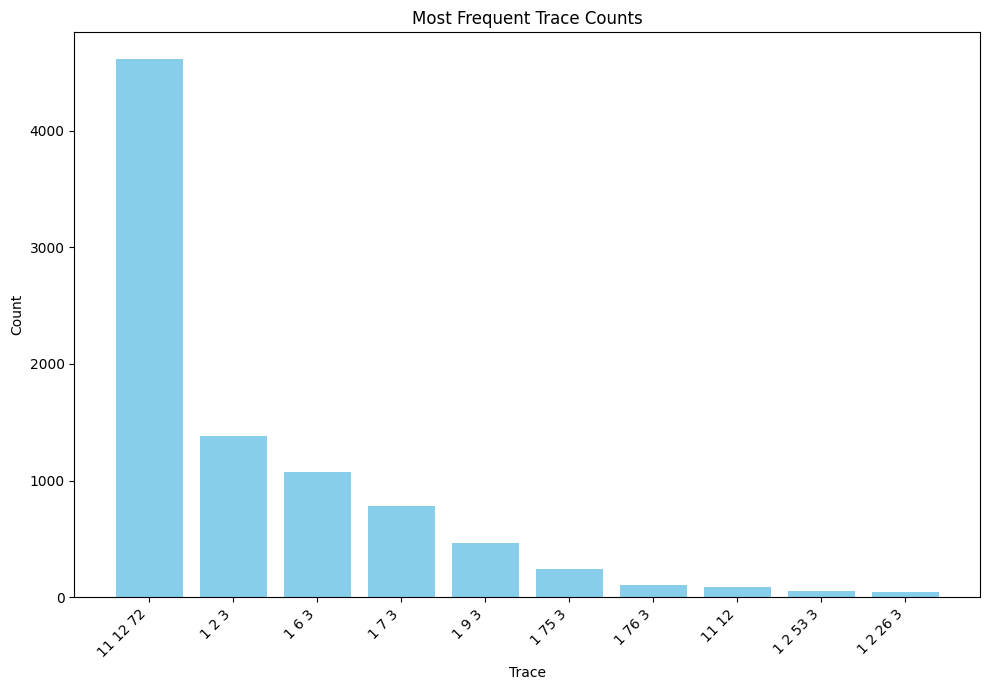

In [59]:
# Read the trace counts from CSV
trace_counts = pd.read_csv('trace_counts.csv')

def remove_consecutive_duplicates(trace):
    numbers = trace.split()
    result = [numbers[0]]
    for num in numbers[1:]:
        if num != result[-1]:
            result.append(num)
    return ' '.join(result)

# Apply the function to remove consecutive duplicates
trace_counts['trace'] = trace_counts['trace'].apply(remove_consecutive_duplicates)

# Group by the trace and sum the counts
deduplicated_trace_counts = trace_counts.groupby('trace')['count'].sum().reset_index()

# Sort the DataFrame by count in descending order
deduplicated_trace_counts = deduplicated_trace_counts.sort_values(by='count', ascending=False)

# Export the deduplicated and sorted trace counts to CSV
csv_file_path_deduplicated = 'trace_counts.csv'
deduplicated_trace_counts.to_csv(csv_file_path_deduplicated, index=False)

# Select the top 7 most frequent traces
top_traces = deduplicated_trace_counts.head(10)

# Create a bar chart of the top 7 trace counts
plt.figure(figsize=(10, 7))
plt.bar(top_traces['trace'], top_traces['count'], color='skyblue')
plt.xlabel('Trace')
plt.ylabel('Count')
plt.title('Most Frequent Trace Counts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels

# Save the bar chart to a file
bar_chart_path = 'top_trace_counts_bar_chart.png'
plt.savefig(bar_chart_path)

# Display the bar chart
plt.show()


In [60]:
print(event_label_to_number)

{'emergency_patient': 1, 'ER_PRACTITIONER3': 2, 'releasing': 3, 'B_BED3': 4, 'B_BED25': 5, 'ER_PRACTITIONER4': 6, 'ER_PRACTITIONER5': 7, 'B_BED26': 8, 'ER_PRACTITIONER6': 9, 'B_BED4': 10, 'patient_referal': 11, 'time_for_intake': 12, 'INTAKE3': 13, 'OR1': 14, 'A_BED20': 15, 'INTAKE2': 16, 'OR4': 17, 'B_BED11': 18, 'INTAKE1': 19, 'OR2': 20, 'A_BED1': 21, 'INTAKE4': 22, 'OR3': 23, 'A_BED15': 24, 'B_BED17': 25, 'B_BED5': 26, 'OR5': 27, 'A_BED16': 28, 'B_BED31': 29, 'A_BED14': 30, 'B_BED18': 31, 'A_BED8': 32, 'B_BED35': 33, 'A_BED18': 34, 'A_BED17': 35, 'B_BED32': 36, 'B_BED27': 37, 'B_BED12': 38, 'A_BED19': 39, 'A_BED21': 40, 'B_BED8': 41, 'A_BED22': 42, 'A_BED2': 43, 'A_BED30': 44, 'A_BED3': 45, 'A_BED28': 46, 'B_BED33': 47, 'A_BED23': 48, 'B_BED37': 49, 'A_BED4': 50, 'A_BED9': 51, 'B_BED19': 52, 'B_BED6': 53, 'B_BED30': 54, 'B_BED28': 55, 'B_BED9': 56, 'B_BED7': 57, 'B_BED29': 58, 'B_BED21': 59, 'B_BED38': 60, 'A_BED29': 61, 'A_BED24': 62, 'B_BED34': 63, 'B_BED13': 64, 'B_BED40': 65, 'B

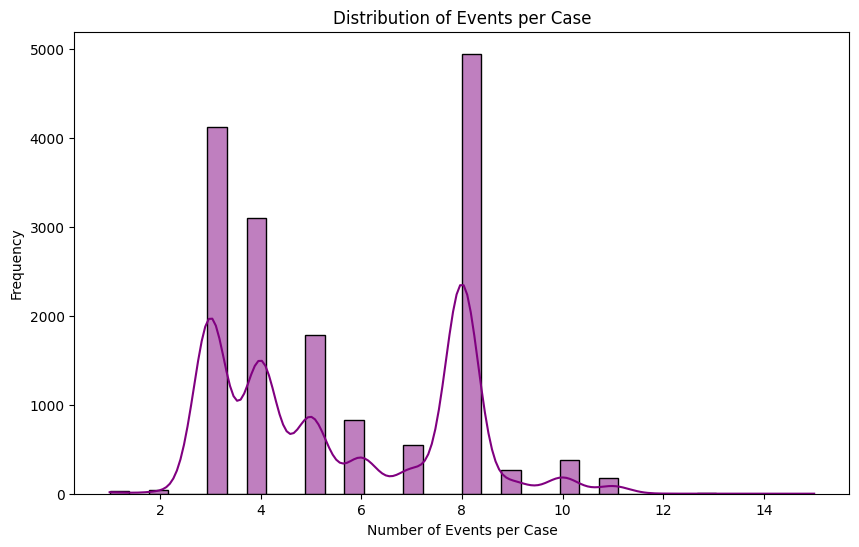

count    16238.000000
mean         5.569036
std          2.266640
min          1.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         15.000000
Name: case:concept:name, dtype: float64


In [61]:
# Count the number of events per case
case_event_counts = sorted_df['case:concept:name'].value_counts()

# Plot the distribution of case lengths
plt.figure(figsize=(10, 6))
sns.histplot(case_event_counts, kde=True, color='purple')
plt.title('Distribution of Events per Case')
plt.xlabel('Number of Events per Case')
plt.ylabel('Frequency')
plt.show()

# Display the case event counts
print(case_event_counts.describe())

c:\Users\dvi44\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:335: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  artist = func([], [], label=label, **use_kws)
c:\Users\dvi44\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:335: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  artist = func([], [], label=label, **use_kws)
c:\Users\dvi44\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:335: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  artist = func([], [], label=l

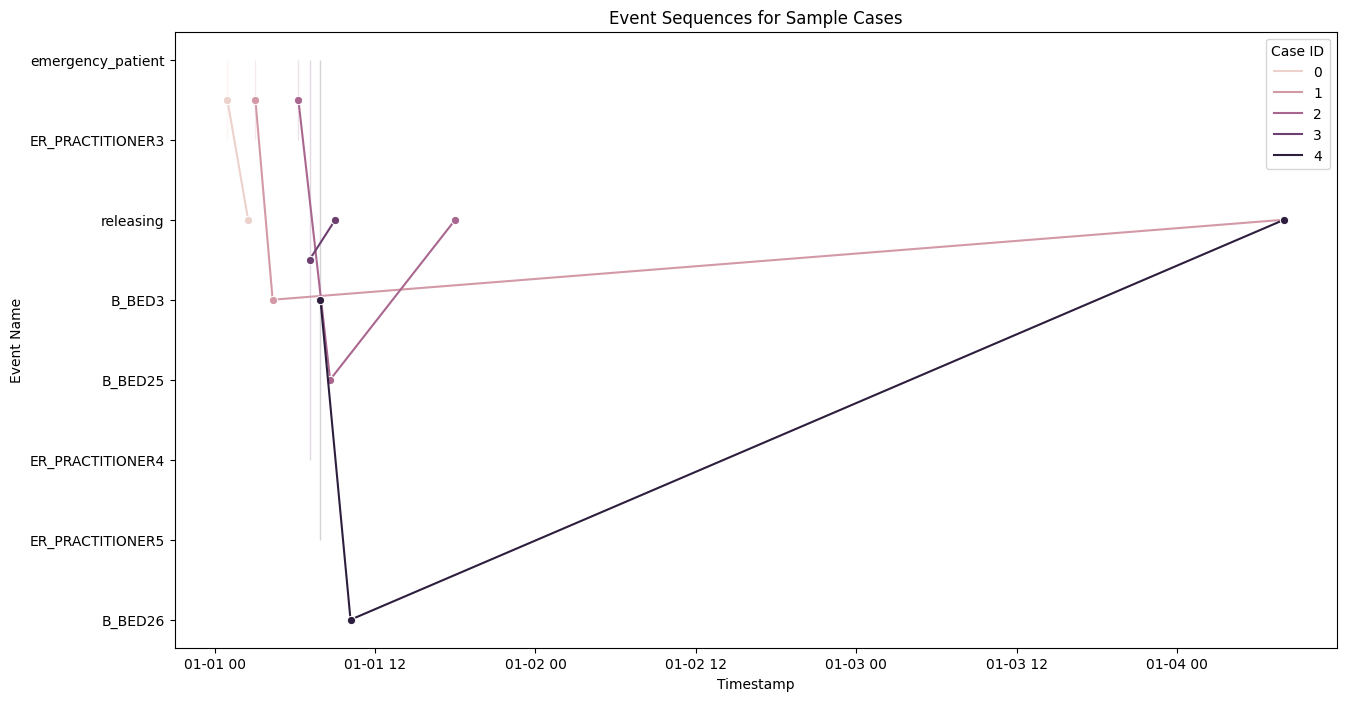

In [62]:
# Select a few cases to visualize
sample_cases = sorted_df[sorted_df['case:concept:name'].isin(sorted_df['case:concept:name'].unique()[:5])]

# Plot the event sequences for the selected cases
plt.figure(figsize=(15, 8))
sns.lineplot(x='time:timestamp', y='concept:name', hue='case:concept:name', data=sample_cases, marker='o')
plt.title('Event Sequences for Sample Cases')
plt.xlabel('Timestamp')
plt.ylabel('Event Name')
plt.legend(title='Case ID')
plt.show()

In [63]:
# Prepare the data for sequence mining
cases = sorted_df.groupby('case:concept:name')['concept:name'].apply(list).values

# Encode the data
te = TransactionEncoder()
te_ary = te.fit(cases).transform(cases)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply the apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.3, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the results
print(frequent_itemsets)
print(rules)

    support                            itemsets
0  0.509299                 (emergency_patient)
1  0.490701                   (patient_referal)
2  0.706429                         (releasing)
3  0.488607                   (time_for_intake)
4  0.507944      (emergency_patient, releasing)
5  0.488607  (patient_referal, time_for_intake)
           antecedents          consequents  antecedent support  \
0  (emergency_patient)          (releasing)            0.509299   
1          (releasing)  (emergency_patient)            0.706429   
2    (patient_referal)    (time_for_intake)            0.490701   
3    (time_for_intake)    (patient_referal)            0.488607   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.706429  0.507944    0.997340  1.411804  0.148160  110.355871   
1            0.509299  0.507944    0.719031  1.411804  0.148160    1.746456   
2            0.488607  0.488607    0.995733  2.037902  0.248847  119.846460   
3           

# Conformance Checking

### Reply Method

### Aliganments Method